# Wildfires

This repository is a mess, so when in doubt, run code from the notebook.

# Format data

In [1]:
import pandas as pd
from sklearn.preprocessing import normalize
import numpy as np

def process(row):
    return np.pad(np.nan_to_num(row), (3080 - len(row), 0))

merge = pd.read_csv("merge.csv")
merge = merge.sort_values(['longitude', 'latitude'])
merge['datetime'] = pd.to_datetime(merge['datetime'])
merge = merge.loc[merge['datetime'].apply(lambda value: value.minute % 10 == 0)]
grouped = merge.groupby('datetime')

wind = grouped['speed'].apply(process).to_list()
fire = grouped['Power'].apply(process).to_list()
wind = normalize(wind) * 10
fire = normalize(fire) * 10

# Define and train model

In [2]:
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.optim as optim


class MLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_count):
        super(MLP, self).__init__()

        feature_cnt = np.linspace(input_size, output_size, hidden_count, dtype=int)
        self.layers = nn.ModuleList([nn.Linear(feature_cnt[i], feature_cnt[i + 1]) for i in range(len(feature_cnt) - 1)])
        print(self.layers)
        self.relu = nn.ReLU()

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i < len(self.layers) - 1:
                x = self.relu(x)

        return x


class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.from_numpy(features).float()
        self.labels = torch.from_numpy(labels).float()

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [3]:
def train(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    train_loss = []
    test_loss = []

    for epoch in range(num_epochs):
        total_loss = 0.0
        test_loss.append(test(model, criterion, test_loader))

        for i, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        train_loss.append(total_loss)

        # Print the average loss for this epoch
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader)}')

    return train_loss, test_loss


def test(model: MLP, criterion, dl):
    model.eval()
    total_loss = 0
    for i, (inputs, labels) in enumerate(dl):
        predicted = model(inputs)
        loss = criterion(predicted, labels)
        total_loss += loss.item()

    return total_loss

In [4]:
from torch.utils.data import DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

data = np.hstack((fire, wind))
print("Data shape:", data.shape)

train_x, test_x, train_y, test_y = train_test_split(data[:-1], fire[1:])
train_dl = DataLoader(CustomDataset(train_x, train_y), batch_size=10, shuffle=True)
test_dl = DataLoader(CustomDataset(test_x, test_y), batch_size=10, shuffle=True)

epochs = 10
loss_func = nn.MSELoss()
mlp = MLP(data.shape[1], fire.shape[1], 5)
print(mlp.layers)
train_loss, test_loss = train(mlp, train_dl, test_dl, loss_func, optim.SGD(mlp.parameters(), lr=0.01), epochs)


def plot_loss(train_loss, test_loss):
    plt.plot(range(1, len(train_loss) + 1), train_loss, label="Training loss")
    plt.plot(range(1, len(test_loss) + 1), test_loss, label="Test loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss ($L2$)")
    plt.legend()
    plt.show()


plot_loss(train_loss, test_loss)

Data shape: (1313, 6160)
ModuleList(
  (0): Linear(in_features=6160, out_features=5390, bias=True)
  (1): Linear(in_features=5390, out_features=4620, bias=True)
  (2): Linear(in_features=4620, out_features=3850, bias=True)
  (3): Linear(in_features=3850, out_features=3080, bias=True)
)
ModuleList(
  (0): Linear(in_features=6160, out_features=5390, bias=True)
  (1): Linear(in_features=5390, out_features=4620, bias=True)
  (2): Linear(in_features=4620, out_features=3850, bias=True)
  (3): Linear(in_features=3850, out_features=3080, bias=True)
)
Epoch [1/10], Loss: 0.027945497929297312


KeyboardInterrupt: 

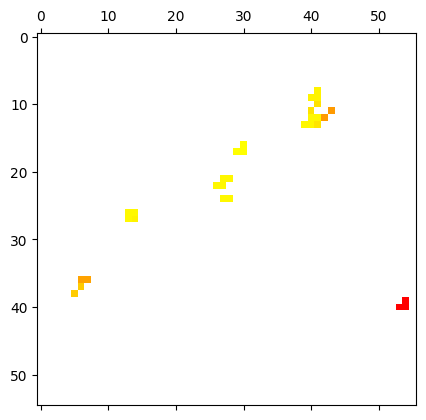

In [39]:
fig = plt.figure()
arr = fire[1300]
arr[arr == 0] = np.nan
axis = plt.matshow(arr.reshape(55, 56), fignum=fig, cmap="autumn_r")